In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import logging
from datetime import datetime

import requests
from tqdm import tqdm, tqdm_notebook, trange

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.dvid import *
from neuclease.dvid.keyvalue import fetch_keyvalues
from neuclease.util import Timer, closest_approach
from neuclease.merge_table import normalize_recarray_inplace, generate_focused_assignment, generate_assignments
from neuclease.focused.ingest import *
from neuclease.focused.ingest import fetch_focused_decisions
from neuclease.focused.scores import calc_speculative_scores
from neuclease.focused.favorites import compute_favorites, mark_favorites, extract_favorites

In [3]:
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = [5, 5]

In [4]:
#import imp
#import neuclease.dvid.kafka
#imp.reload(neuclease.dvid.kafka)
#from neuclease.dvid.kafka import read_kafka_messages

In [5]:
from DVIDSparkServices.spark_launch_scripts.janelia_lsf.lsf_utils import get_hostgraph_url
print("This notebook:")
print(get_hostgraph_url(os.environ["LSB_JOBID"]))
#print("Cluster:")
#print(get_hostgraph_url(os.environ["MASTER_BJOB_ID"]))

This notebook:
http://lsf-rtm/cacti/plugins/grid/grid_bjobs.php?action=viewjob&tab=hostgraph&clusterid=1&indexid=0&jobid=46497749&submit_time=1536343895


In [6]:
root_logger = logging.getLogger()
root_logger.handlers = []
configure_default_logging()

In [7]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

In [8]:
sc

''

### UUIDS

In [58]:
# The starting agglo
initial_agglo_node = ('emdata3:8900', 'ac901')

# # The uuid used when loading the neo4j instance (for 'important bodies')
# neo4j_reference = DvidInstanceInfo('emdata3:8900', '52f9', 'segmentation')

# # The last supervoxel splits: One past the neo4j node
analysis_node = ('emdata3:8900', '662e')

# Current master
master_node = ('emdata3:8900', '9e0d')

### Analysis Node mapping

In [10]:
#msgs = read_kafka_messages(*analysis_node, 'segmentation', consumer_timeout=4.0)

In [11]:
analysis_mapping = fetch_complete_mappings(*analysis_node, 'segmentation')

INFO [2018-09-07 14:20:03,058] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata3:8900 / 662e / segmentation
INFO [2018-09-07 14:20:36,848] Reading 911374 kafka messages took 33.78953313827515 seconds
INFO [2018-09-07 14:20:44,051] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings...
INFO [2018-09-07 14:21:18,389] Fetching http://emdata3:8900/api/node/662e/segmentation/mappings took 0:00:34.336402
INFO [2018-09-07 14:21:18,390] Parsing mapping...
INFO [2018-09-07 14:21:25,800] Parsing mapping took 0:00:07.410044
INFO [2018-09-07 14:21:25,856] Constructing missing identity-mappings...
INFO [2018-09-07 14:21:47,785] Constructing missing identity-mappings took 0:00:21.928757


In [12]:
#analysis_mapping = fetch_mappings(*analysis_node, 'segmentation')

In [13]:
analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

### Previous decisions

In [59]:
%%time
LOAD_PREVIOUS_FROM_CSV = False
_path = f'focused-decisions-{master_node[1]}-{datetime.now().date()}.csv'

if LOAD_PREVIOUS_FROM_CSV:
    df = pd.read_csv(_path)
    df.fillna(0.0, inplace=True)
    df['sv_a'] = df['sv_a'].astype(np.uint64)
    df['sv_b'] = df['sv_b'].astype(np.uint64)
    df['body_a'] = df['body_a'].astype(np.uint64)
    df['body_b'] = df['body_b'].astype(np.uint64)
    previous_focused_decisions = df
else:
    previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                         normalize_pairs='sv')

    previous_focused_decisions.to_csv(_path, index=False, header=True)

# Body info is nearly useless because they correspond to the body ID
# at the time the edge was assigned -- not the current body ID.
# Let's delete the body columns to ensure we don't accidentally try to use it for anything.
del previous_focused_decisions['body_a']
del previous_focused_decisions['body_b']

previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

assert previous_focused_decisions.eval('id_a <= id_b').all()
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

Loaded 530289 previous decisions
CPU times: user 58.7 s, sys: 5.47 s, total: 1min 4s
Wall time: 1min 33s


TOTAL decisions: 530289
Merge(later) Decisions: 282385 (53.3%)


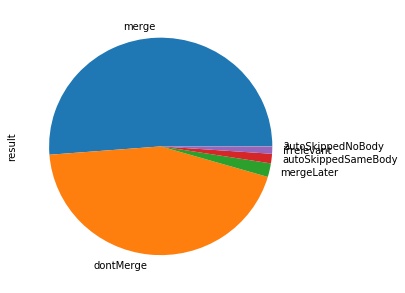

In [60]:
print(f"TOTAL decisions: {len(previous_focused_decisions)}")
merge_decisions = previous_focused_decisions.eval('result == "merge" or result == "mergeLater"').sum()
merge_rate = merge_decisions / len(previous_focused_decisions)
print(f"Merge(later) Decisions: {merge_decisions} ({100*merge_rate:.1f}%)")
previous_focused_decisions['result'].value_counts().plot(kind='pie')

In [16]:
def drop_previously_reviewed(df, previous_focused_decisions_df):
    """
    Given a DataFrame of speculative focused decisions and 
    a DataFrame of previously reviewed focused decisions,
    drop all previous decisions from the speculative set,
    regardless of review results.
    """
    comparison_df = previous_focused_decisions_df[['id_a', 'id_b']].drop_duplicates()
    in_prev = df[['id_a', 'id_b']].merge(comparison_df,
                                         how='left',
                                         on=['id_a', 'id_b'],
                                         indicator='side')

    keep_rows = (in_prev['side'] == 'left_only')
    return df[keep_rows.values]

### Important bodies

In [17]:
##
## Using Analysis node state!
##

#focused_bodies_path = 'focused-7254-2tbars-2psds-10.0Mv.npy'
focused_bodies_path = 'focused-662e-2tbars-2psds-10.0Mv.npy'
focused_bodies_table = pd.DataFrame(np.load(focused_bodies_path))
focused_bodies_table.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies_table.query('PreSyn >= 2 or PostSyn >= 10 or voxel_count >= 10e6', inplace=True)

important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

Working with 702995 focused bodies


### Recent, limited to 160k group (no "second-favorites")

In [64]:
recent_no_second_favorites = load_focused_table('remaining-onehop-assignments-7254-20180824.csv')

In [65]:
recent_no_second_favorites.head()

,id_a,id_b,body_a,body_b,xa,ya,za,xb,yb,zb,score
0,978215387,978216166,978215387,359913281,10726,20941,13865,10740,20910,13867,-0.164567
1,2180107316,2180452882,5813024833,1870483009,16954,10118,30845,16947,10081,30876,-0.998103
2,1590940221,1590940303,5812990497,1498176639,32150,10377,22590,32194,10354,22608,-0.988324
3,1046549486,1077588372,1046549307,388280297,23783,28680,15010,23741,28640,15019,-0.172622
4,1563444916,2024133404,5812993175,1962072998,4637,8953,28349,4632,8918,28397,-0.996784


In [66]:
recent_no_second_favorites['body_a'] = analysis_mapper.apply(recent_no_second_favorites['id_a'].values, True)
recent_no_second_favorites['body_b'] = analysis_mapper.apply(recent_no_second_favorites['id_b'].values, True)

In [67]:
recent_no_second_favorites.head()

,id_a,id_b,body_a,body_b,xa,ya,za,xb,yb,zb,score
0,978215387,978216166,978215387,359913281,10726,20941,13865,10740,20910,13867,-0.164567
1,2180107316,2180452882,5813024833,1870483009,16954,10118,30845,16947,10081,30876,-0.998103
2,1590940221,1590940303,5812990497,1498176639,32150,10377,22590,32194,10354,22608,-0.988324
3,1046549486,1077588372,1046549307,388280297,23783,28680,15010,23741,28640,15019,-0.172622
4,1563444916,2024133404,5812993175,1962072998,4637,8953,28349,4632,8918,28397,-0.996784


In [68]:
# Remove previously reviewed
_merged = recent_no_second_favorites[['id_a', 'id_b']].merge(previous_focused_decisions[['id_a', 'id_b']],
                                                             how='left',
                                                             on=['id_a', 'id_b'],
                                                             indicator='source_table')
unreviewed_pos = (_merged['source_table'] == 'left_only')
recent_no_second_favorites_unreviewed = recent_no_second_favorites.loc[unreviewed_pos].copy()

In [69]:
focused_bodies_table.head()

,voxel_count,sv_count,PostSyn,PreSyn
body,,,,
1497973422,11818299675,8719,8308,65
5813024096,10985904465,8126,7393,109
263199096,9674671304,2650,51,34
262840563,9591276440,3957,386,468
5813021092,9522426145,10636,2933,1160


In [70]:
# Remove edges between "old" bodies (i.e. 2 tbars on both sides.)
recent_no_second_favorites_unreviewed = recent_no_second_favorites_unreviewed.merge(focused_bodies_table,
                                            how='inner', left_on='body_a', right_index=True)
recent_no_second_favorites_unreviewed = recent_no_second_favorites_unreviewed.merge(focused_bodies_table,
                                            how='inner', left_on='body_b', right_index=True,
                                           suffixes=['_a', '_b'])

# Remove edges that involve two bodies that already had >= 2 t-bars
# (How did these make it into the set?)
filtered_table = recent_no_second_favorites_unreviewed.query('not (PreSyn_a >= 2 and PreSyn_b >= 2)')
#filtered_table.to_csv('remaining-onehop-assignments-7254-20180905.csv', index=False, header=True)

In [71]:
generate_assignments(filtered_table, 5000, 'remaining-onehop-assignments-7254-20180907')

100%|██████████| 11/11 [00:01<00:00,  6.79it/s]


In [72]:
filtered_table.shape

(59724, 19)

In [50]:
#recent_no_second_favorites_unreviewed[recent_no_second_favorites_unreviewed[['id_a', 'id_b']].values == [1932777456, 1933118423]]
recent_no_second_favorites_unreviewed.query('id_a == 1932777456 and id_b == 1933118423')

,id_a,id_b,body_a,body_b,xa,ya,za,xb,yb,zb,score,voxel_count_a,sv_count_a,PostSyn_a,PreSyn_a,voxel_count_b,sv_count_b,PostSyn_b,PreSyn_b
23638,1932777456,1933118423,5813022932,1932777341,9134,11543,27246,9169,11483,27207,-0.625019,1726258766,1392,3076,397,85683,3,11,0


In [ ]:
previous_focused_decisions['body_a'] = analysis_mapper.apply(previous_focused_decisions['id_a'].values, True)
previous_focused_decisions['body_b'] = analysis_mapper.apply(previous_focused_decisions['id_b'].values, True)

In [63]:
previous_focused_decisions.query('id_a == 1932777456 and id_b == 1933118423')
#previous_focused_decisions.query('body_a == 5813022932 and body_b == 1932777341')

,build version,initial 3D angle method,result,result history,source,id_a,id_b,time,time to complete (ms),time zone,user,using hybrid meshes,xa,xb,ya,yb,za,zb
286593,neu3-develop-0.1.post1420-0_g6e6e408,method 1 (normal to acquisition axis Z),merge,[merge],/groups/flyem/data/hemi_brain/whole_hemi_brain...,1932777456,1933118423,2018-09-07T14:13:47,[255704],EDT,smithk2,True,9149.0,9149.0,11506.0,11505.0,27223.0,27222.0


In [62]:
import requests
r = requests.get('http://emdata3:8900/api/node/9e0d/segmentation_merged/key/1932777456+1933118423')
r.status_code

200

### Decisions

In [55]:
recent_no_2nd_fav_decisions = recent_decisions.merge(recent_no_second_favorites[['id_a', 'id_b']],
                                                     how='inner', on=['id_a', 'id_b'])

NameError: name 'recent_decisions' is not defined

In [ ]:
rno2f = recent_no_2nd_fav_decisions['result'].value_counts()
(rno2f['merge'] + rno2f['mergeLater']) / rno2f.sum()

In [ ]:
recent_new_subset = recent_no_2nd_fav_decisions.query('PreSyn_a < 2 or PreSyn_b < 2')

In [ ]:
new_subset_counts = recent_new_subset['result'].value_counts()

In [ ]:
(new_subset_counts['merge'] + new_subset_counts['mergeLater']) / new_subset_counts.sum()

### Unrelated: Check tarsupervoxels status

In [14]:
master_focused_table = pd.DataFrame(np.load('focused-9e0d-2tbars-10psds-10.0Mv.npy'))
master_focused_table.head()

,body,voxel_count,sv_count,PostSyn,PreSyn
0,1497973422,12385573026,8953,8397,66
1,5813024096,10992947053,8172,7393,111
2,262840563,10492068511,6347,764,647
3,263199096,10129123402,2867,72,50
4,947573616,9261844618,7916,18638,4494


In [15]:
missing_svs = pd.read_csv('missing-focused-svs-9e0d.csv', dtype=np.uint64)

In [22]:
statuses = []
for start in trange(0, len(missing_svs), 10_000):
    sv_batch = missing_svs['sv'].iloc[start:start+10_000].values
    statuses.append( fetch_exists('emdata3:8900', '9e0d', 'segmentation_sv_meshes', sv_batch) )

100%|██████████| 15/15 [00:01<00:00,  8.62it/s]


In [25]:
missing_svs['exists'] = pd.concat(statuses).values

In [28]:
(~missing_svs['exists']).sum()

188

In [33]:
pd.Series(pd.unique(missing_svs.query('not exists and size > 100')['body']), name='body')\
  .to_csv('straggler-bodies-9e0d.csv')